# Example 2 Gaussian Distribution

Consider a data set to be modeled as a gaussian distribution where the mean, $\mu$, and variance $\sigma$ of the distribution are unknown.

Assume that the parameter priors are given by,

$
\begin{align}
\mu    &\sim \mathcal{U}(l_\mu, h_\mu) \\
\sigma &\sim \mathcal{HN}(\sigma_\sigma)
\end{align}
\tag{1}
$

where $\mathcal{U}(l_\mu, h_\mu)$ is a Uniform distribution between $l_\mu$ amd $h_\mu$ and $\mathcal{HN}(\sigma_\sigma)$ a HalfNormal distribution with scale $\sigma_\sigma$. 
The distribution of the data is assumed to have the form,

$
\begin{align}
Y \sim \mathcal{N}(\mu, \sigma)
\end{align}
\tag{2}
$

It follows that the likelihood function is given by,

$
\begin{align}
P[Y\, | \mu,\sigma] = \frac{1}{\sigma\sqrt{2\pi}}e^{\left(\frac{\left(y - \mu\right)}{\sigma}\right)^2}
\end{align}
\tag{3}
$

In [72]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, bar, twinx_bar_line, fcurve_scatter_comparison, positive_negative_bar)

pyplot.style.use(config.glyfish_style)

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "/Users/troy/.pyenv/versions/3.11.2/envs/pymc-3.11.2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/troy/.pyenv/versions/3.11.2/envs/pymc-3.11.2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/troy/.pyenv/versions/3.11.2/lib/python3.11/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


In [73]:
mu_true = 50
sigma_true = 5

l_mu, h_mu = 40, 75
mu_prob = 1.0 / (h_mu - l_mu)
sigma_sigma = 5

mu_vals = numpy.linspace(0, 100, 100)
sigma_vals = numpy.linspace(0.0, 20, 50)

mu_pdf = numpy.where((mu_vals >= l_mu) & (mu_vals <= h_mu), mu_prob, 0)
sigma_pdf = numpy.abs(stats.norm.pdf(sigma_vals, 0, sigma_sigma))
sigma_pdf = sigma_pdf / sigma_pdf.sum()

obs_data = numpy.random.normal(mu_true, sigma_true, 100)

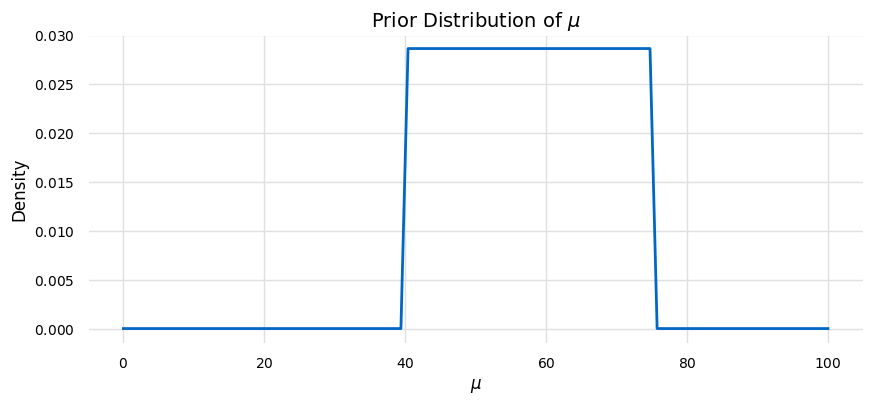

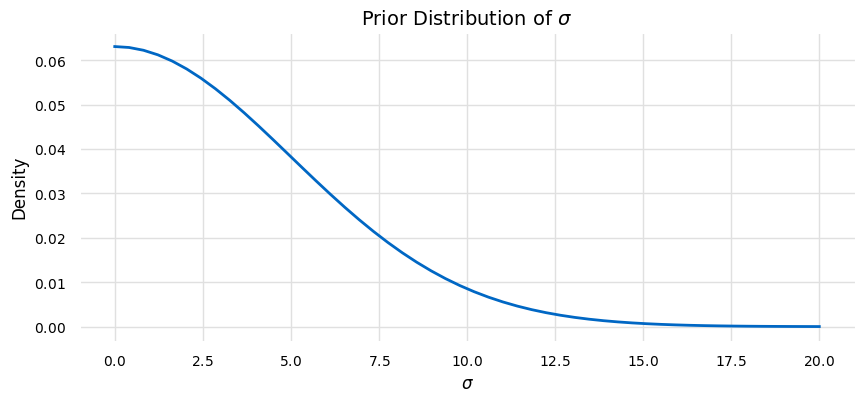

In [74]:
title = 'Prior Distribution of $\mu$'
curve(mu_pdf, mu_vals, title=title, xlabel='$\mu$', ylabel='Density', figsize=(10, 4))

title = 'Prior Distribution of $\sigma$'
curve(sigma_pdf, sigma_vals, title=title, xlabel='$\sigma$', ylabel='Density', figsize=(10, 4))


## pyMC

In [75]:
with pymc.Model() as model:
    mu = pymc.Uniform('mu', l_mu, h_mu)
    sigma = pymc.HalfNormal('sigma', sigma=sigma_sigma)
    data = pymc.Normal('data', mu=mu, sigma=sigma, observed=obs_data)

    idata = pymc.sample(1000, tune=1000, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


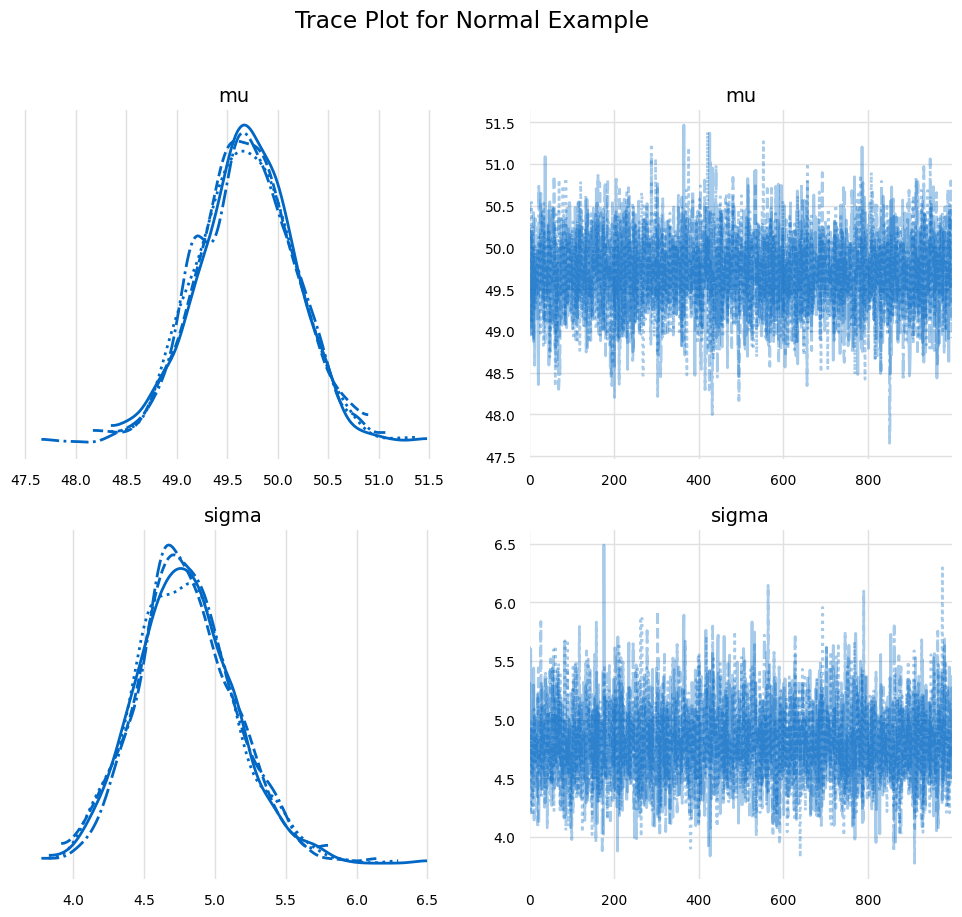

In [76]:
arviz.plot_trace(idata, figsize=(12, 10))
_ = pyplot.suptitle('Trace Plot for Normal Example')

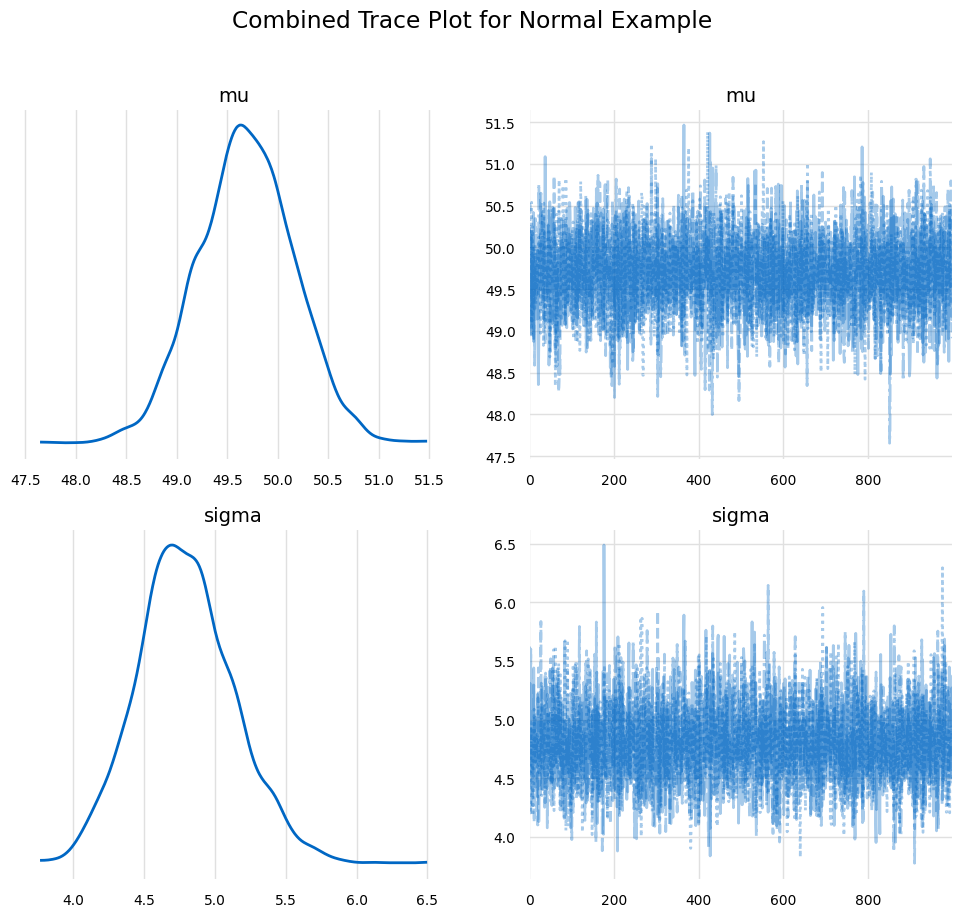

In [77]:
arviz.plot_trace(idata, figsize=(12, 10), combined=True)
_ = pyplot.suptitle('Combined Trace Plot for Normal Example')

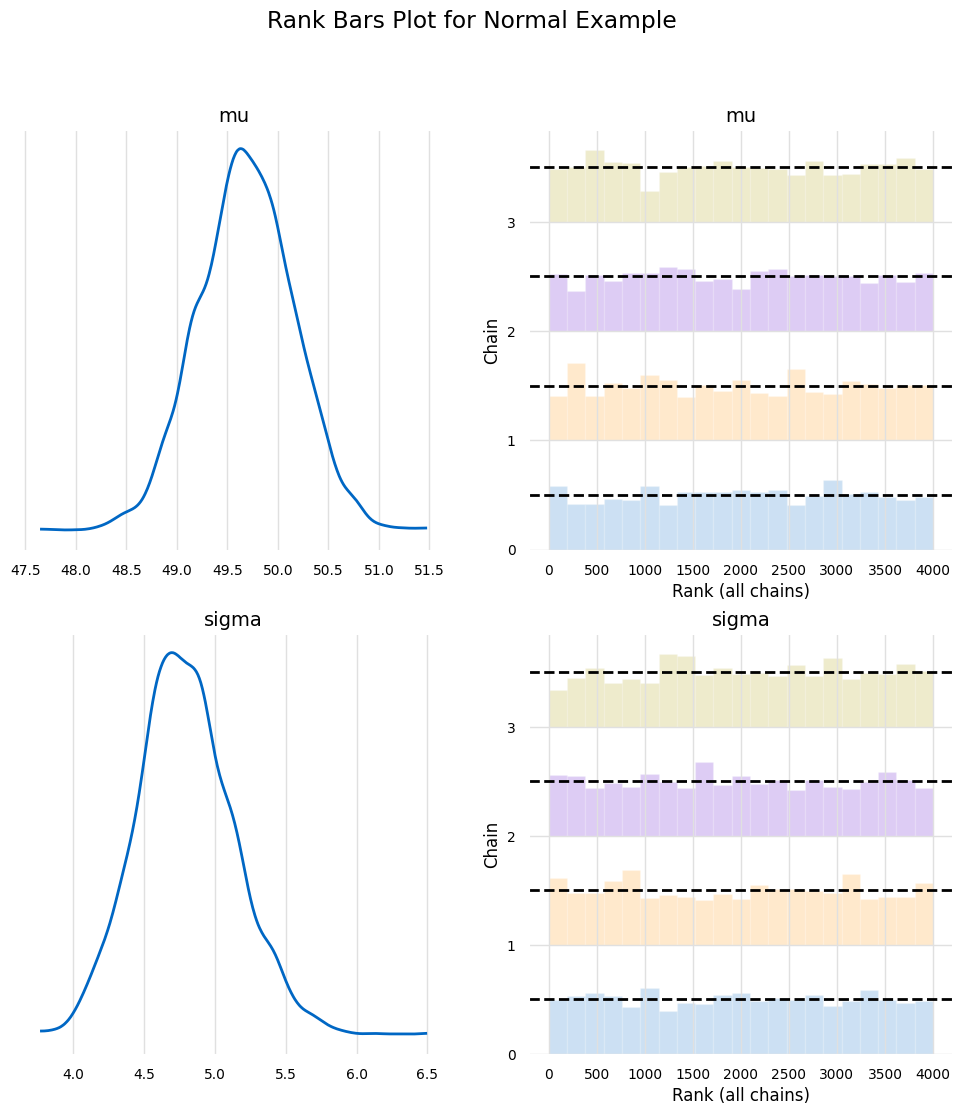

In [78]:
arviz.plot_trace(idata, kind='rank_bars', combined=True, figsize=(12, 12))
_ = pyplot.suptitle('Rank Bars Plot for Normal Example')

In [79]:
arviz.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,49.68,0.47,48.82,50.56,0.01,0.01,3678.0,2774.0,1.0
sigma,4.79,0.34,4.17,5.45,0.01,0.00,3872.0,2589.0,1.0


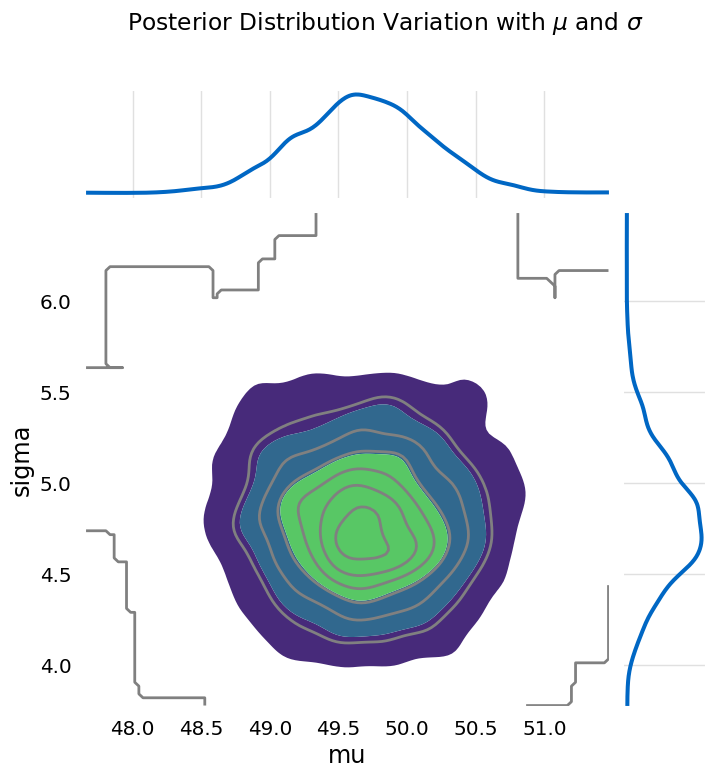

In [83]:
arviz.plot_pair(idata, kind='kde', marginals=True, figsize=(8, 8))
_ = pyplot.suptitle('Posterior Distribution Variation with $\mu$ and $\sigma$')

## Posterior Predictive Checks

From the posterior distribution $P[\theta | Y]$ can be used to generate predictions $P[\hat{Y}]$. The posterior predictive distribution is defined by,

$
\begin{align}
P[\hat{Y}] = \int P[\hat{Y} | \theta ]\ P[\theta | Y] d\theta
\end{align}
$

### Bayesian Posterior Predictive

The **Bayesian posterior predictive distribution** is a fundamental concept in Bayesian statistics. It represents the distribution of potential future observations given the data you have already observed. It combines the uncertainty in the parameter estimates (encoded in the posterior distribution) with the likelihood of future data given those parameters.

#### Mathematical Formulation

The posterior predictive distribution is defined as:

$
p(y_{\text{new}} \mid \mathbf{y}) = \int p(y_{\text{new}} \mid \theta) p(\theta \mid \mathbf{y}) \, d\theta
$

Where:
- $y_{\text{new}}$: A new observation or future data point.
- $\mathbf{y}$: The observed data.
- $p(\theta \mid \mathbf{y})$: The posterior distribution of the parameters \(\theta\) given the observed data \(\mathbf{y}\).
- $p(y_{\text{new}} \mid \theta)$: The likelihood of new data given the parameters \(\theta\).

#### Intuition

1. **Posterior Uncertainty**: The posterior $p(\theta \mid \mathbf{y})$ represents your updated belief about the parameters after observing data.
2. **Prediction**: You use the likelihood $p(y_{\text{new}} \mid \theta)$ to predict new data given a particular value of the parameters.
3. **Integration**: By averaging over all possible parameter values (weighted by their posterior probabilities), the posterior predictive incorporates both parameter uncertainty and model predictions.

#### Steps in Practice

1. **Compute the Posterior**: Determine \(p(\theta \mid \mathbf{y})\) using Bayes' theorem.
2. **Predict Future Data**: For each possible value of \(\theta\), calculate \(p(y_{\text{new}} \mid \theta)\).
3. **Integrate**: Combine predictions across all \(\theta\), weighted by their posterior probabilities.

#### Uses of Posterior Predictive

- **Model Validation**: Compare posterior predictive samples to observed data to check model fit.
- **Prediction**: Generate predictions for future or unseen data points.
- **Uncertainty Quantification**: Provide uncertainty intervals for predictions that account for parameter uncertainty.

#### Example

Suppose you have a dataset $\mathbf{y}$ and a model where the data follows a Gaussian distribution:

$
y \sim \mathcal{N}(\mu, \sigma^2)
$

1. **Posterior**: After observing $\mathbf{y}$, compute $p(\mu, \sigma^2 \mid \mathbf{y})$.
2. **Likelihood**: For a new data point $y_{\text{new}}$, the likelihood is:

    $
   p(y_{\text{new}} \mid \mu, \sigma^2) \sim \mathcal{N}(\mu, \sigma^2)
    $

3. **Posterior Predictive**: Combine the above using the posterior:

    $
   p(y_{\text{new}} \mid \mathbf{y}) = \int \mathcal{N}(y_{\text{new}} \mid \mu, \sigma^2)\ p(\mu, \sigma^2 \mid \mathbf{y}) \, d\mu \, d\sigma^2
    $

This integration accounts for the uncertainty in \(\mu\) and \(\sigma^2\) based on the observed data.

#### Key Insights

- The posterior predictive distribution is **data-driven** but also accounts for model and parameter uncertainty.
- It allows probabilistic predictions, making it fundamental in Bayesian workflows.

In [81]:
_ = pymc.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)

Sampling: [data]


Output()

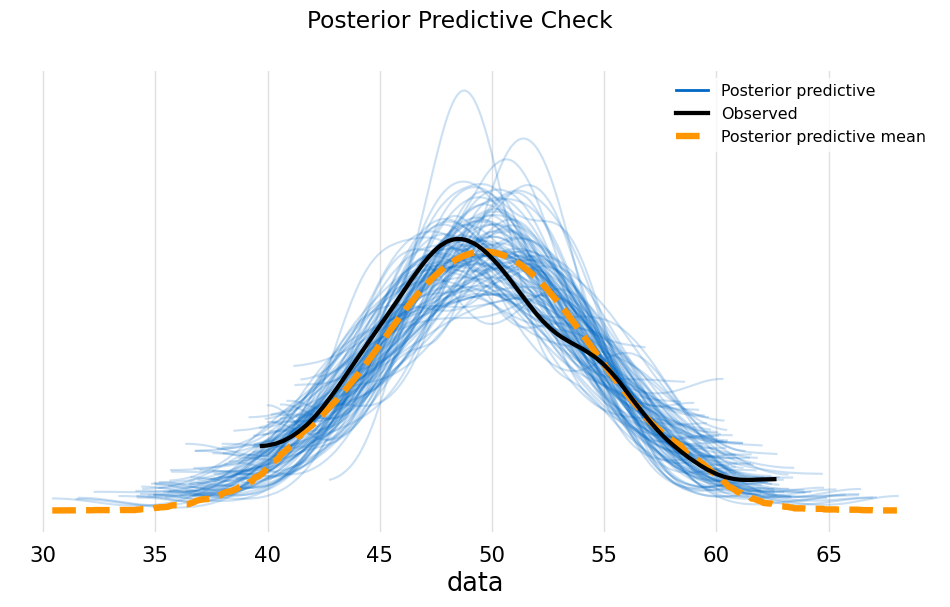

In [82]:
arviz.plot_ppc(idata, num_pp_samples=100, figsize=(12, 6))
_ = pyplot.suptitle('Posterior Predictive Check')